In [1]:
import torch
from torch import nn
from torchvision import transforms
from pathlib import Path

from dataset import *
from data_preprocessing import *
from utils import *
from diffusers.models import AutoencoderKL
from unet import *
from attention import *
from time_embedding import *
from ddpm import *

In [2]:
batch_size = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device).requires_grad_(False)
ddpm = DDPM(0.0001, 0.02, 1000, device)
unet = UNET(n_classes=2, in_channels=4, out_channels=4, channels=(32,64,128,256)).to(device)

In [4]:
train_data_folder = "./data/256/"
train_latent_folder = Path("./data/latents256/")
test_data_folder = "./data/256test/"
test_latent_folder = Path("./data/latents256test/")


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, a=0.1)
unet.apply(init_weights);

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.Lambda(lambda x: x.float())
            ])

In [ ]:
data_to_latents(model=vae, 
                  data_folder=train_data_folder, 
                  latent_folder=train_latent_folder, 
                  transform=transform, 
                  batch_size=5, 
                  shuffle=True
               )

data_to_latents(model=vae, 
                  data_folder=test_data_folder, 
                  latent_folder=test_latent_folder, 
                  transform=transform, 
                  batch_size=5, 
                  shuffle=False
               )

In [5]:
latent_transform = transforms.Compose([
                # transforms.ToTensor(), 
                transforms.Normalize(mean=[-1.2638,  0.7728,  0.6195, -0.9007], std=[6.1378, 7.1625, 4.4116, 5.5606]),
                # transforms.Lambda(lambda x: x.float())
            ])


In [5]:
train_latent_dl = latent_dataloader(latent_folder=train_latent_folder, 
                                    latent_transform=None, 
                                    batch_size=batch_size, 
                                    shuffle=True
                                )

test_latent_dl = latent_dataloader(latent_folder=test_latent_folder, 
                                    latent_transform=None, 
                                    batch_size=batch_size, 
                                    shuffle=False
                                )

tensor([-0.4632,  1.3821,  0.6638, -1.0129], device='cuda:0')
tensor([6.1326, 7.4040, 4.3331, 5.5146], device='cuda:0')


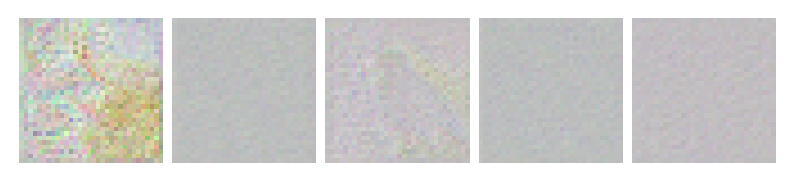

In [16]:
# for X, y in train_latent_dl:
#     X, y = X.to(device), y.to(device)
#     print(X.mean((0, 2, 3)))
#     print(X.std((0, 2, 3)))
#     xt, t, noise = ddpm.schedule(X)
#     pred = unet(xt, t, y)
#     show_images_grid(pred)
#     break

In [17]:
lr = 1e-2
epochs = 300
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_latent_dl))

In [18]:
from IPython.display import display
from tqdm.notebook import trange

def train(model, epochs=None):
    model.to(device)
    progress_bar = trange(epochs, desc="Progress")
    display(progress_bar)
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        for X, y in train_latent_dl:
            X, y = X.to(device), y.to(device)
            xt, t, noise = ddpm.schedule(X)
            pred = model(xt, t, y)
            loss = loss_fn(pred, noise)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        schedular.step()
        current_epoch = epoch+1

        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            for val_X, val_y in test_latent_dl:
                val_X, val_y = val_X.to(device), val_y.to(device)
                val_xt, val_t, val_noise = ddpm.schedule(val_X)
                val_pred = model(val_xt, val_t, val_y)
                val_loss = loss_fn(val_pred, val_noise)
                total_val_loss += val_loss.item()

        torch.save(model.state_dict(), f"./Saved Models/unet_{current_epoch}.pth")
        print(f"Epoch: {current_epoch} - Loss: {total_loss/len(train_latent_dl)} | Val Loss: {total_val_loss/len(test_latent_dl)}")

In [19]:
train(unet, epochs=100)

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 - Loss: 1.001684594154358 | Val Loss: 0.9778673052787781
Epoch: 2 - Loss: 0.8829081058502197 | Val Loss: 0.8187576532363892
Epoch: 3 - Loss: 0.7997655391693115 | Val Loss: 0.6989811062812805
Epoch: 4 - Loss: 0.6894825577735901 | Val Loss: 0.6852762699127197
Epoch: 5 - Loss: 0.6520563125610351 | Val Loss: 0.6537288129329681
Epoch: 6 - Loss: 0.59918971657753 | Val Loss: 0.5704161524772644
Epoch: 7 - Loss: 0.5704524368047714 | Val Loss: 0.561457484960556
Epoch: 8 - Loss: 0.5585990965366363 | Val Loss: 0.591992050409317
Epoch: 9 - Loss: 0.5733194768428802 | Val Loss: 0.5315161645412445
Epoch: 10 - Loss: 0.5320121139287949 | Val Loss: 0.4467929005622864
Epoch: 11 - Loss: 0.5365317970514297 | Val Loss: 0.581545889377594
Epoch: 12 - Loss: 0.5218904972076416 | Val Loss: 0.41954630613327026
Epoch: 13 - Loss: 0.5029528081417084 | Val Loss: 0.5408195704221725
Epoch: 14 - Loss: 0.5010557174682617 | Val Loss: 0.4514966309070587
Epoch: 15 - Loss: 0.5179360926151275 | Val Loss: 0.47079306840

In [ ]:
# unet.load_state_dict(torch.load("./Saved Models/unet_.pth"))

In [20]:
bird_sample = ddpm.sample(unet, (5, 4, 32, 32), torch.tensor(0))

torch.Size([5, 3, 256, 256])


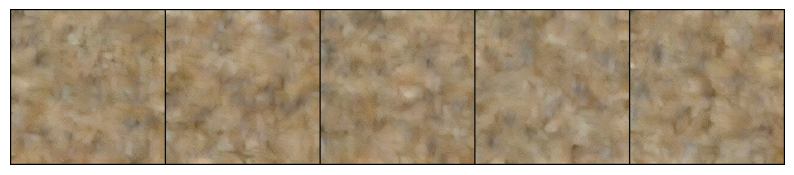

In [22]:
bird_image = vae.decode(bird_sample[0])
print(bird_image["sample"].shape)
show_images_grid(bird_image["sample"], grid_size=5)

In [ ]:
dog_sample = ddpm.sample(unet, (5, 4, 32, 32), torch.tensor(1))
show_images_grid(dog_sample["sample"])

In [ ]:
dog_image = vae.decode(dog_sample)["sample"]
show_images_grid(dog_image)